In [2]:
from distutils.dir_util import copy_tree
from_dir = '../input/forknet'#'../input/d/albaalba/forknet'
to_dir = ''

copy_tree(from_dir, to_dir)
!pip install torchsummary
!pip install hiddenlayer

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from mcmc_samplers import SGHMCSampler,LossModule
from ResForkNet import *
import utils as ut
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from collections import OrderedDict
import matplotlib.pyplot as plt
import hiddenlayer as hl
from IPython.display import display, clear_output
import os
import datetime


plt.style.use('ggplot')
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [4]:
transform = ut.ToTensor()
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX',
         'EA','NFLX','VZ','ACN','ADBE','AMD','ADI','AKAM','AMAT','CSCO','CTXS','IBM','MSI','ORCL','QCOM','WU']
dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = 30,transform = transform)
lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
train_set, test_set = torch.utils.data.random_split(dataset, lengths)
train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(dataset, batch_size=len(dataset),
                        shuffle=False, num_workers=0)

(3308, 60, 810) (3308, 27)

In [5]:
model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2, ll_sizes = [10,100,64])
model.load_state_dict(torch.load('model_27stocks_month11',map_location = torch.device(device)))
model = model.to(device)
#summary(model, input_size = (60,30*len(stocks)))

graph = hl.build_graph(model.cpu(), torch.zeros([1, 67, 29*len(stocks)]))
graph.save(path="Network" , format="png")
graph

In [ ]:
loss_fn = torch.nn.MSELoss(reduction='sum')
lm = LossModule(model,train_loader, loss_fn, N = len(train_set))
#SGHMC = SGHMCSampler(lm, num_burn_in_steps=3000, lr = 0.0007, keep_every=100)
#SGHMC.sample(nsamples=300)
SGHMC = SGHMCSampler(lm, num_burn_in_steps=30, lr = 0.0007, keep_every=2)
SGHMC.sample(nsamples=3)
sampled_weights = SGHMC.sampled_weights
#torch.save(model.state_dict(),"model_27stocks_month11")

In [ ]:
ut.plot_predictions_from_samples(sampled_weights, model, stocks, test_loader, dataset, window = 30, pred_window = 30, num_f = 60, show_days = 100, savefig = False)

In [ ]:
os.makedirs('models')
for i, set_params in enumerate(sampled_weights[0:-1:10]):       
    state_dict = {}
    for k,(name, param) in enumerate(model.named_parameters()):
        state_dict[name] = torch.from_numpy(set_params[k])
    state_dict_it = OrderedDict(state_dict)
    model.load_state_dict(state_dict_it, strict=False)
    torch.save(model.state_dict(),"models/mm27_{}".format(i))
!zip -r models.zip models/


Building the loaders(3308, 60, 810) (3308, 27)
Sampling 1050/1050ing 1/48
Sampling 1050/1050ing 2/48
Sampling 1050/1050ing 3/48
Sampling 1050/1050ing 4/48
Sampling 1050/1050ing 5/48
Sampling 1050/1050ing 6/48
Sampling 1050/1050ing 7/48
Sampling 1050/1050ing 8/48
Sampling 1050/1050ing 9/48
Sampling 1050/1050ing 10/48
Sampling 1050/1050ing 11/48
Sampling 1050/1050ing 12/48
Sampling 1050/1050ing 13/48
Sampling 1050/1050ing 14/48
Sampling 1050/1050ing 15/48
Sampling 1050/1050ing 16/48
Sampling 1050/1050ing 17/48
Sampling 1050/1050ing 18/48
Sampling 1050/1050ing 19/48
Sampling 1050/1050ing 20/48
Sampling 1050/1050ing 21/48
Sampling 1050/1050ing 22/48
Sampling 1050/1050ing 23/48
Sampling 1050/1050ing 24/48
Sampling 1050/1050ing 25/48
Sampling 1050/1050ing 26/48
Sampling 1050/1050ing 27/48
Sampling 1050/1050ing 28/48
Sampling 1050/1050ing 29/48
Sampling 1050/1050ing 30/48
Sampling 1050/1050ing 31/48
Sampling 1050/1050ing 32/48
Sampling 1050/1050ing 33/48
Sampling 1050/1050ing 34/48
Sampling 

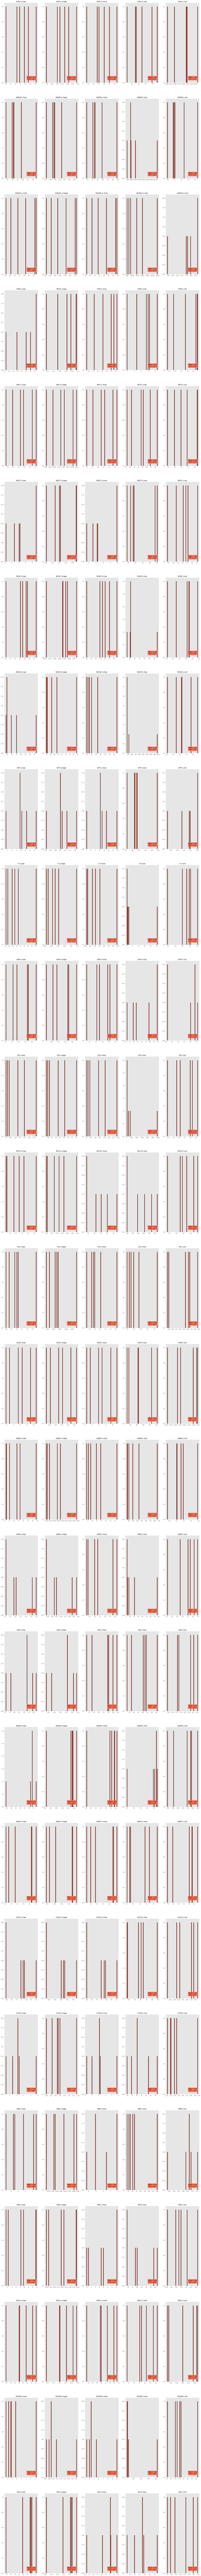

In [6]:
ut.plot_hist_errors(stocks, (model, "model_27stocks_month11"), window =30, pred_window = 30, batch_size=64, savefig = True)